# Finding interrelations of the UN SDG Targets and impute missing observations

### This project is divided into two major phases: 
1. It is intended to find cliques within the [UN SDG](https://sustainabledevelopment.un.org/?menu=1300) Targets.
2. Within one of the found cliques, missing observations of the time-series are inferred

Each Target has at least one quantitatively measurable Indicator associated whose measurements from 1984 to 2017 serve as our data points. The data set we are working with is for the entire world, i.e. the values presented are means over all countries. Regarding the first phase, for a more sophisticated analysis, but out of scope of this course, correlations in each country should be analysed separately.

<img src="Screenshot from 2018-04-19 10-08-40.png">

## 1. Find cliques

Import necessary packages and load our preprocessed data set

*if you want to see what happened in the preprocessing, see **prepare_df_for_analysis.ipynb** *

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import math
import os

In [2]:
# load csv
df = pd.read_csv("TargetsForAnalysis.csv")
df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,NaN
1,107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN


See how many data points we have for each Indicator

In [3]:
intyears = list(range(1984, 2018))
#print(intyears)

years = []
for year in intyears:
    years.append(str(year))
    
#print(years)

In [4]:
def getnumberofyearswithdata(r):
    n = 0
    for year in years:
        if ~np.isnan(r[year]):
            n+=1
    return n

In [5]:
# new column with number of data points per Indicator
df['Years with values'] = df.apply(getnumberofyearswithdata, axis=1)

In [6]:
df.head()
df.shape

(197, 43)

We need at least two data points to conclude any kind of correlation

In [7]:
df_new = df.loc[df['Years with values'] > 1]

# see how many rows we deleted
print(df_new.shape)
df_new.head()

(120, 43)


,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN,2
8,115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,...,NaN,69.88,NaN,NaN,NaN,NaN,NaN,78.49,NaN,3
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.20,66.59,NaN,NaN,NaN,12
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
11,131,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN,16


See how many Targets are associated with the Indicators we found

In [8]:
# create a list of Targets
e = list(df_new['Target'])
type(e[2])

str

In [9]:
df_new['Target'] = df_new.apply(lambda x: str(x['Target']), axis=1)

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
df_new.shape

(120, 43)

See which Targets are in our data frame

In [11]:
targets = list(set(df_new['Target']))

We know that one Target can have potentially more than one Indicator, and that Indicators can be separetely measured for, e.g., genders, age groups, etc.
But since we want to find interrelations between the Targets, only the row per Target with maximum amount of data is considered.

In [12]:
# create empty dictionary
target_dfs = {}

In [13]:
for t in targets:
    target_dfs[t] = df_new[df_new['Target']==t]

In [14]:
# show an example of Target with more than on Indicator
target_dfs['12.2']

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.690000e+00,1.010000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
178,78,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
179,79,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,6.573055e+16,6.932903e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
183,83,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,9.750000e+00,1.006000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
184,84,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
185,85,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,6.807354e+16,7.099971e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [15]:
# find row with maximum amount of data points for each target
max_dfrows = {}

for target in targets:
    if target_dfs[target].shape[0] > 1:
        max_dfrows[target] = target_dfs[target].loc[target_dfs[target]['Years with values'].idxmax()].to_frame().T
    else:
        max_dfrows[target]=target_dfs[target]

In [16]:
frames = list(max_dfrows[target] for target in targets)

In [17]:
merged_df = pd.concat(frames, axis=0)

In [18]:
units = list(set(merged_df['Unit']))

In [19]:
units.remove('Percent')
units

['Metric Tons', 'USD', 'Constant USD']

In [20]:
not_percent = merged_df[merged_df['Unit'].isin(units)]
not_percent

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9
174,74,Environment (Tonnes),"Material footprint, material footprint per cap...",8,8.4,8.4.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
140,20,E&P (Percent),"Net official development assistance, total and...",17,17.2,17.2.1,Constant USD,Billions,NaN,NaN,...,0.000114281,0.00012063,0.000119673,0.000115308,0.000121838,0.000123946,0.000131555,0.000143329,NaN,17
191,95,Environment (Tonnes),CO2 emission per unit of value added,9,9.4,9.4.1,Metric Tons,Units,NaN,NaN,...,2.87486e+10,3.04504e+10,3.13544e+10,3.15929e+10,3.21294e+10,3.2381e+10,NaN,NaN,NaN,15


In [21]:
merged_df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
48,177,Population (Percent),Prevalence of undernourishment,2,2.1,2.1.1,Percent,Units,NaN,NaN,...,12.5,12.1,11.8,11.4,11.2,11,10.8,NaN,NaN,25
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
157,56,Environment (percent),Proportion of important sites for terrestrial ...,15,15.1,15.1.2,Percent,Units,NaN,NaN,...,41.7,41.93,42.18,42.7,43.01,43.19,43.23,43.23,43.23,18
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9
103,167,Population,Researchers (in full-time equivalent) per mill...,9,9.5,9.5.2,Percent,Millions,NaN,NaN,...,100.752,101.895,104.668,106.636,108.754,109.838,NaN,NaN,NaN,15


### clean-up data frames

In [22]:
# Drop unused columns, transpose
final_df = merged_df.copy()

final_df.drop(['Unnamed: 0', 'Category', 'Indicator Description', 'Goal', 'Indicator Ref', 'Unit',
              'Unit multiplier', 'Years with values'], inplace=True, axis=1)

final_df = final_df.set_index('Target')

final_t = final_df.T

targets = list(final_t.columns)

In [23]:
final_t

Target,2.1,12.2,15.1,17.19,9.5,8.4,17.8,17.3,3.9,3.1,...,3.6,14.5,9.4,6.2,15.2,16.a,3.3,8.1,1.1,7.2
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991,18.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,18.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993,18.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# shuffle data
final_t_shuffled = final_t.sample(frac=1).reset_index(drop=True)
final_t_shuffled

Target,2.1,12.2,15.1,17.19,9.5,8.4,17.8,17.3,3.9,3.1,...,3.6,14.5,9.4,6.2,15.2,16.a,3.3,8.1,1.1,7.2
0,16.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.2,NaN,43.01,4.43106e+08,108.754,NaN,37.18,0.69,NaN,NaN,...,1.74,NaN,3.21294e+10,25.48,NaN,NaN,14.7,1.08,10.7,18.19
3,NaN,NaN,43.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,14.3,9.42,39.42,1.62618e+08,92.935,9.42,17.46,0.58,NaN,NaN,...,NaN,NaN,2.78903e+10,30.32,NaN,NaN,16.6,2.77,NaN,16.97
6,10.8,NaN,43.23,NaN,NaN,NaN,43.75,0.76,0.147,21.6,...,NaN,11.92,NaN,23.97,NaN,35.5,14.2,1.45,NaN,NaN
7,16.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Structure Learning

We learn the structure of the network by deploying linear regression and calculate error measurements. In detail, we say that a correlation between two Targets exists, if the mean average error (MAE) is lower than 1%.

In [25]:
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import Imputer

In [26]:
def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    
    if len(trues)>2:
        rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
        r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    else:
        rae = np.nan
        r2 = np.nan
    return mae, rae, rmse, r2

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


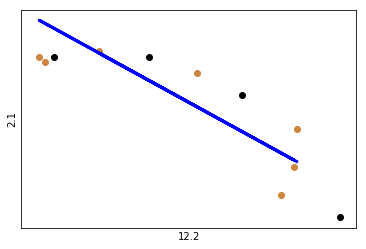

12.2 2.1
MAE: 0.49797
RMSE: 0.56480
R2: 0.668
Coefficient -1.4168296570982801
--------------------------




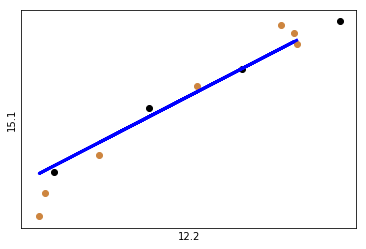

12.2 15.1
MAE: 0.87901
RMSE: 1.08730
R2: 0.918
Coefficient 3.8024669025788307
--------------------------


17.19 12.2
MAE: 0.14585
RMSE: 0.20473
R2: 0.000
Coefficient 3.590706962069515e-09
--------------------------


17.19 9.5
MAE: 6.26518
RMSE: 7.19747
R2: 0.000
Coefficient 5.5021775279494296e-08
--------------------------


17.19 8.4
MAE: 0.14585
RMSE: 0.20473
R2: 0.000
Coefficient 3.590706962069515e-09
--------------------------


17.19 17.8
MAE: 7.88213
RMSE: 9.11688
R2: 0.000
Coefficient 6.897460941647549e-08
--------------------------


17.19 17.3
MAE: 0.05267
RMSE: 0.05919
R2: 0.000
Coefficient 3.8875885727591903e-10
--------------------------


17.19 15.4
MAE: 1.86859
RMSE: 2.15917
R2: 0.000
Coefficient 1.643737990895701e-08
--------------------------


17.19 6.1
MAE: 2.28233
RMSE: 2.86741
R2: 0.000
Coefficient 2.2296405690219974e-08
--------------------------


17.19 4.2
MAE: 2.76960
RMSE: 3.23277
R2: 0.000
Coefficient 2.120808369022683e-08
--------------------------


17.19 

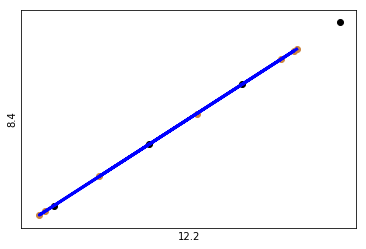

12.2 8.4
MAE: 0.00000
RMSE: 0.00000
R2: 1.000
Coefficient 0.9999999999999998
--------------------------


12.2 17.8
MAE: 1.64838
RMSE: 1.97561
R2: 0.917
Coefficient 8.800465794620749
--------------------------




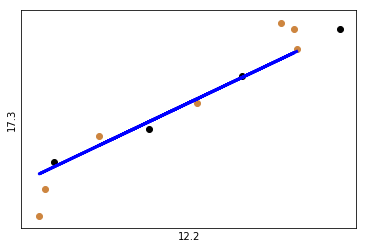

12.2 17.3
MAE: 0.02887
RMSE: 0.03608
R2: 0.887
Coefficient 0.10222609128217884
--------------------------




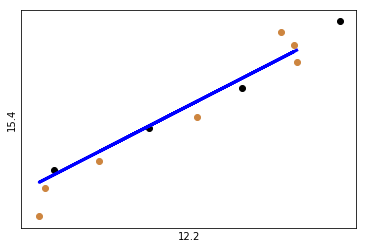

12.2 15.4
MAE: 0.67435
RMSE: 0.78012
R2: 0.925
Coefficient 3.0836395292308745
--------------------------




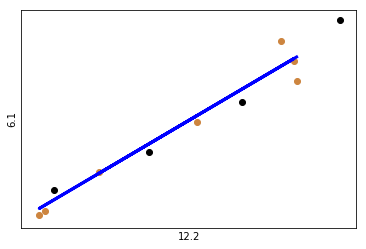

12.2 6.1
MAE: 0.77164
RMSE: 1.04479
R2: 0.955
Coefficient 6.305570315768049
--------------------------




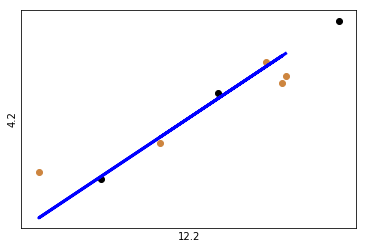

12.2 4.2
MAE: 0.52446
RMSE: 0.64728
R2: 0.622
Coefficient 2.9522948225186516
--------------------------


12.2 8.2
MAE: 1.42576
RMSE: 2.03384
R2: 0.000
Coefficient 1.2460571389809048
--------------------------


12.2 14.4
MAE: 5.13487
RMSE: 5.60100
R2: 0.000
Coefficient -1.8461538461538494
--------------------------


12.2 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.787
Coefficient 2.2258885902929302e-05
--------------------------


12.2 9.c
MAE: 6.52152
RMSE: 10.49310
R2: 0.259
Coefficient 16.752789680161897
--------------------------




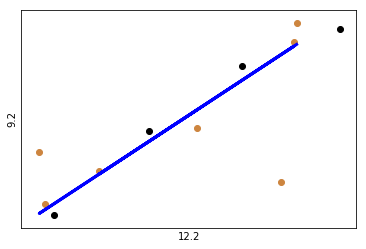

12.2 9.2
MAE: 0.18438
RMSE: 0.29176
R2: 0.296
Coefficient 0.5033860555561835
--------------------------


9.4 12.2
MAE: 0.06227
RMSE: 0.07383
R2: 0.990
Coefficient 3.0839820500628596e-10
--------------------------




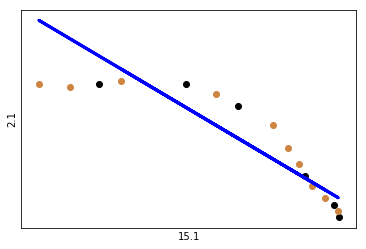

15.1 2.1
MAE: 0.77675
RMSE: 0.97298
R2: 0.583
Coefficient -0.4955320158695137
--------------------------


17.19 15.1
MAE: 1.47982
RMSE: 1.72762
R2: 0.000
Coefficient 1.2868033665820289e-08
--------------------------


17.19 6.2
MAE: 1.93458
RMSE: 2.22303
R2: 0.000
Coefficient -1.6833397868902845e-08
--------------------------


17.19 3.3
MAE: 0.75926
RMSE: 0.86118
R2: 0.000
Coefficient -6.627655603887507e-09
--------------------------


17.19 8.1
MAE: 1.94217
RMSE: 2.88678
R2: 0.000
Coefficient -5.07241305367723e-09
--------------------------


17.19 7.2
MAE: 0.60643
RMSE: 0.65668
R2: 0.000
Coefficient 4.1226039001570595e-09
--------------------------


17.19 2.1
MAE: 1.28482
RMSE: 1.46681
R2: 0.000
Coefficient -1.113774416710585e-08
--------------------------




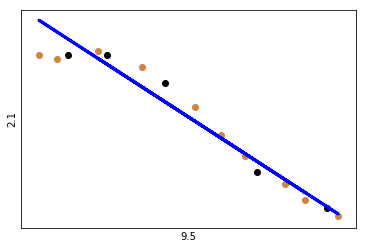

9.5 2.1
MAE: 0.29771
RMSE: 0.40876
R2: 0.926
Coefficient -0.16566798465603305
--------------------------


9.5 15.1
MAE: 1.10496
RMSE: 1.31370
R2: 0.891
Coefficient 0.3286810855660927
--------------------------


8.4 9.5
MAE: 1.41446
RMSE: 1.80079
R2: 0.939
Coefficient 9.170079479033587
--------------------------


8.4 17.8
MAE: 1.64838
RMSE: 1.97561
R2: 0.917
Coefficient 8.800465794620749
--------------------------




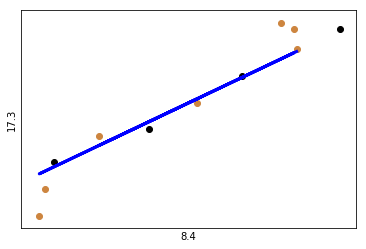

8.4 17.3
MAE: 0.02887
RMSE: 0.03608
R2: 0.887
Coefficient 0.10222609128217884
--------------------------




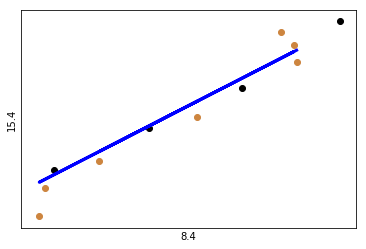

8.4 15.4
MAE: 0.67435
RMSE: 0.78012
R2: 0.925
Coefficient 3.0836395292308745
--------------------------




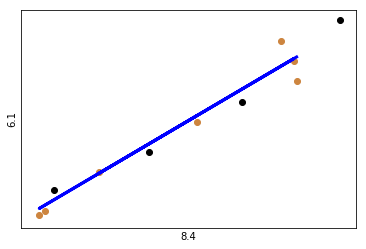

8.4 6.1
MAE: 0.77164
RMSE: 1.04479
R2: 0.955
Coefficient 6.305570315768049
--------------------------




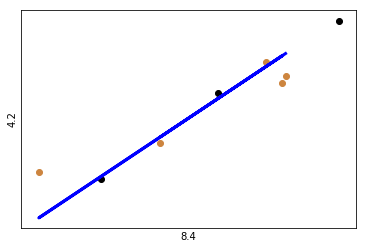

8.4 4.2
MAE: 0.52446
RMSE: 0.64728
R2: 0.622
Coefficient 2.9522948225186516
--------------------------


8.4 8.2
MAE: 1.42576
RMSE: 2.03384
R2: 0.000
Coefficient 1.2460571389809048
--------------------------


8.4 14.4
MAE: 5.13487
RMSE: 5.60100
R2: 0.000
Coefficient -1.8461538461538494
--------------------------


8.4 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.787
Coefficient 2.2258885902929302e-05
--------------------------


8.4 9.c
MAE: 6.52152
RMSE: 10.49310
R2: 0.259
Coefficient 16.752789680161897
--------------------------




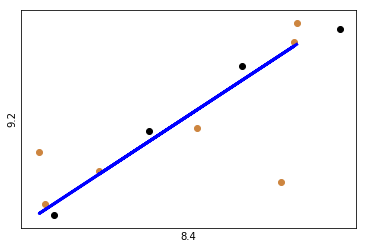

8.4 9.2
MAE: 0.18438
RMSE: 0.29176
R2: 0.296
Coefficient 0.5033860555561835
--------------------------


9.4 8.4
MAE: 0.06227
RMSE: 0.07383
R2: 0.990
Coefficient 3.0839820500628596e-10
--------------------------




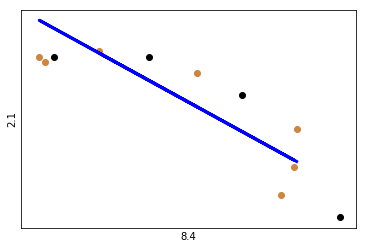

8.4 2.1
MAE: 0.49797
RMSE: 0.56480
R2: 0.668
Coefficient -1.4168296570982801
--------------------------




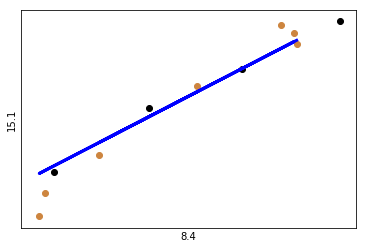

8.4 15.1
MAE: 0.87901
RMSE: 1.08730
R2: 0.918
Coefficient 3.8024669025788307
--------------------------




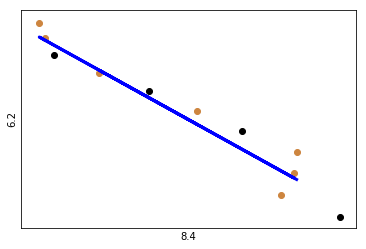

8.4 6.2
MAE: 0.40513
RMSE: 0.50470
R2: 0.935
Coefficient -2.511447015861889
--------------------------




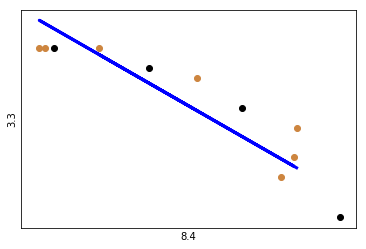

8.4 3.3
MAE: 0.22971
RMSE: 0.25713
R2: 0.754
Coefficient -0.8285943629806327
--------------------------


8.4 8.1
MAE: 1.67854
RMSE: 2.61226
R2: 0.000
Coefficient 0.8783394195656352
--------------------------




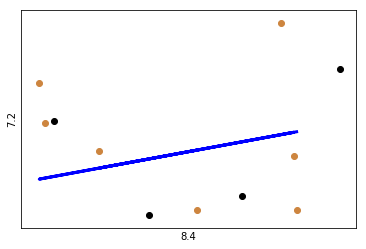

8.4 7.2
MAE: 0.26892
RMSE: 0.30291
R2: 0.000
Coefficient 0.11231077093532095
--------------------------




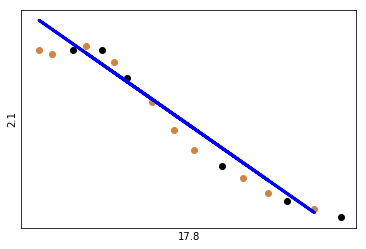

17.8 2.1
MAE: 0.35739
RMSE: 0.41758
R2: 0.923
Coefficient -0.1422333485249808
--------------------------


17.8 15.1
MAE: 1.60526
RMSE: 1.82956
R2: 0.789
Coefficient 0.24736756931778367
--------------------------


17.8 9.5
MAE: 1.20320
RMSE: 1.52414
R2: 0.975
Coefficient 0.934922572464987
--------------------------




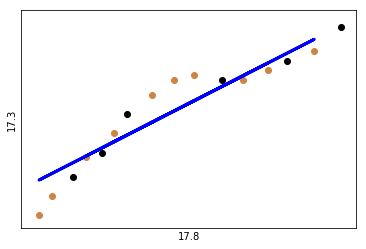

17.8 17.3
MAE: 0.03632
RMSE: 0.04347
R2: 0.849
Coefficient 0.008582947693576704
--------------------------


17.8 3.9
MAE: 0.02456
RMSE: 0.02799
R2: nan
Coefficient -0.0008879781420765034
--------------------------


17.8 3.1
MAE: 3.17172
RMSE: 3.60208
R2: nan
Coefficient -0.2049180327868852
--------------------------




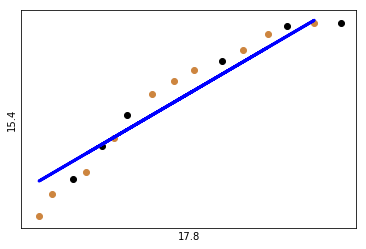

17.8 15.4
MAE: 0.87084
RMSE: 1.00379
R2: 0.915
Coefficient 0.25140847158171536
--------------------------


17.8 6.1
MAE: 2.22007
RMSE: 2.36084
R2: 0.821
Coefficient 0.3673926744850877
--------------------------




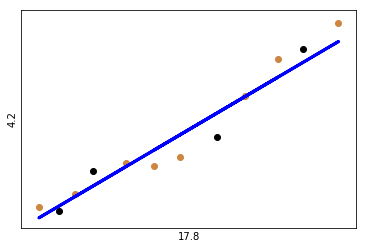

17.8 4.2
MAE: 0.62262
RMSE: 0.75085
R2: 0.949
Coefficient 0.33625305177599885
--------------------------


17.8 8.2
MAE: 1.04480
RMSE: 1.43944
R2: 0.000
Coefficient -0.02429956850353593
--------------------------




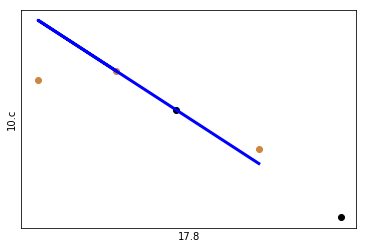

17.8 10.c
MAE: 0.25830
RMSE: 0.36840
R2: 0.000
Coefficient -0.16742770167427695
--------------------------




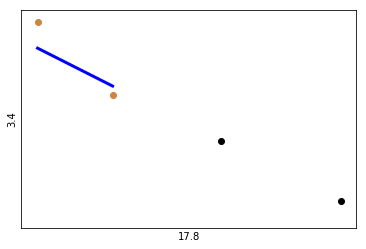

17.8 3.4
MAE: 0.01479
RMSE: 0.01645
R2: nan
Coefficient -0.00341530054644809
--------------------------


17.8 14.4
MAE: 2.82024
RMSE: 3.08666
R2: 0.657
Coefficient 0.2705191267234127
--------------------------


17.2 17.8
MAE: 4.22173
RMSE: 5.57690
R2: 0.736
Coefficient 589020.1077992579
--------------------------


17.2 9.c
MAE: 8.59331
RMSE: 12.35454
R2: 0.219
Coefficient 799923.5620878299
--------------------------


17.2 7.1
MAE: 18.02299
RMSE: 25.16733
R2: nan
Coefficient 856577.5504294957
--------------------------


17.2 9.2
MAE: 0.25705
RMSE: 0.33746
R2: 0.458
Coefficient 22911.197094389678
--------------------------


17.2 3.6
MAE: 1.32860
RMSE: 1.75313
R2: nan
Coefficient -49668.051853446064
--------------------------


17.2 14.5
MAE: 7.02134
RMSE: 8.89791
R2: 0.000
Coefficient 410066.77314977953
--------------------------


9.4 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.839
Coefficient 5.752559818809441e-15
--------------------------




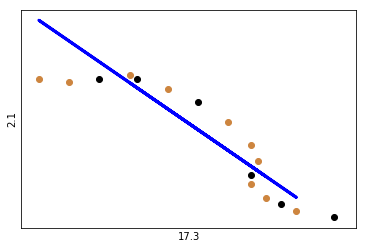

17.3 2.1
MAE: 0.72648
RMSE: 0.85138
R2: 0.681
Coefficient -15.76504713560551
--------------------------




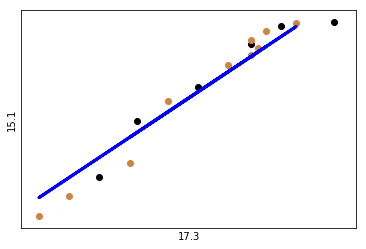

17.3 15.1
MAE: 0.70762
RMSE: 0.83130
R2: 0.956
Coefficient 29.4532269760696
--------------------------


17.3 9.5
MAE: 2.76921
RMSE: 3.36787
R2: 0.880
Coefficient 102.37507477567297
--------------------------




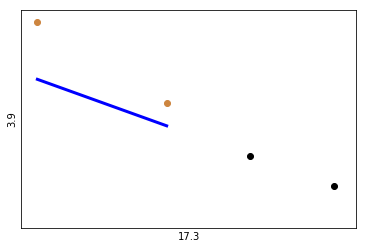

17.3 3.9
MAE: 0.01745
RMSE: 0.01898
R2: nan
Coefficient -0.11818181818181833
--------------------------


17.3 3.1
MAE: 1.53182
RMSE: 1.56734
R2: nan
Coefficient -27.27272727272728
--------------------------




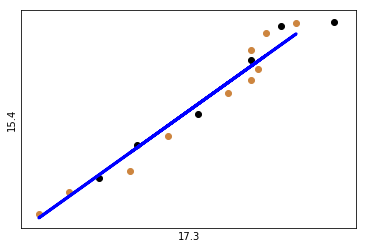

17.3 15.4
MAE: 0.63203
RMSE: 0.69736
R2: 0.959
Coefficient 28.868745467730236
--------------------------


17.3 6.1
MAE: 1.01427
RMSE: 1.43518
R2: 0.934
Coefficient 43.72516316171137
--------------------------


17.3 4.2
MAE: 1.71355
RMSE: 1.98908
R2: 0.642
Coefficient 41.23205741626796
--------------------------


17.3 8.2
MAE: 1.00063
RMSE: 1.39939
R2: 0.000
Coefficient -1.0739666424945609
--------------------------




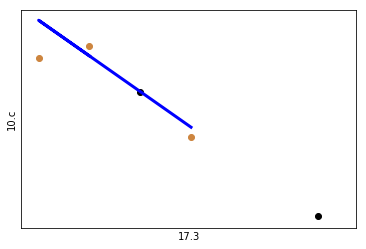

17.3 10.c
MAE: 0.16667
RMSE: 0.20220
R2: 0.677
Coefficient -15.714285714285694
--------------------------




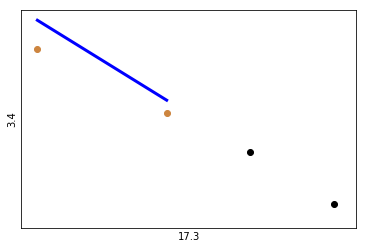

17.3 3.4
MAE: 0.02014
RMSE: 0.02172
R2: nan
Coefficient -0.45454545454545503
--------------------------


17.3 14.4
MAE: 2.48860
RMSE: 3.15575
R2: 0.642
Coefficient 30.329670329670332
--------------------------


17.2 17.3
MAE: 0.03269
RMSE: 0.04260
R2: 0.855
Coefficient 5500.665911299121
--------------------------


17.2 6.2
MAE: 1.02480
RMSE: 1.36716
R2: 0.775
Coefficient -157310.33368372574
--------------------------


17.2 16.a
MAE: 3.46218
RMSE: 3.68441
R2: 0.804
Coefficient 237985.18084585437
--------------------------


17.2 3.3
MAE: 0.49343
RMSE: 0.62456
R2: 0.572
Coefficient -55388.38211841701
--------------------------


17.2 8.1
MAE: 1.27570
RMSE: 1.88129
R2: 0.000
Coefficient 1246.2453465002259
--------------------------


17.2 7.2
MAE: 0.38031
RMSE: 0.42748
R2: 0.013
Coefficient 16092.155982611284
--------------------------


3.9 2.1
MAE: 1.60000
RMSE: 2.06155
R2: nan
Coefficient 99.99999999999982
--------------------------


3.9 15.1
MAE: 2.64000
RMSE: 3.08183
R2: nan
Coe

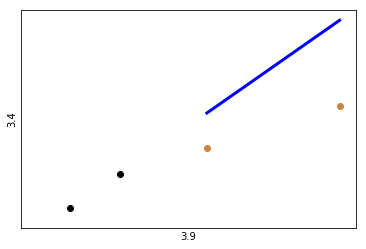

3.9 3.4
MAE: 0.08727
RMSE: 0.09471
R2: nan
Coefficient 3.8461538461538454
--------------------------


17.2 3.9
MAE: 0.00894
RMSE: 0.01181
R2: nan
Coefficient -1189.9259042292722
--------------------------




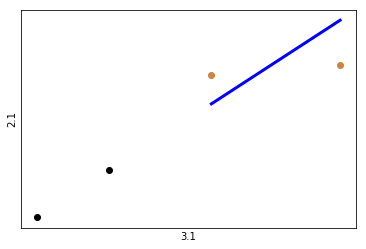

3.1 2.1
MAE: 0.99833
RMSE: 1.02193
R2: nan
Coefficient 0.4333333333333329
--------------------------


3.1 15.1
MAE: 3.72167
RMSE: 4.31905
R2: nan
Coefficient -0.4333333333333323
--------------------------


3.1 15.4
MAE: 1.47700
RMSE: 1.50023
R2: nan
Coefficient -0.6799999999999996
--------------------------


3.1 6.1
MAE: 12.77967
RMSE: 13.44083
R2: nan
Coefficient 0.24666666666666492
--------------------------


3.1 8.2
MAE: 6.73500
RMSE: 7.04740
R2: nan
Coefficient 0.7999999999999999
--------------------------




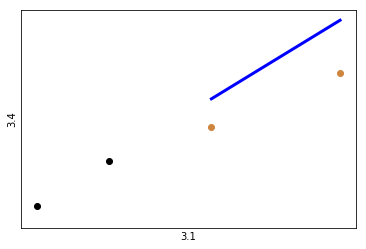

3.1 3.4
MAE: 0.04567
RMSE: 0.04767
R2: nan
Coefficient 0.016666666666666677
--------------------------


17.2 3.1
MAE: 3.45251
RMSE: 3.52608
R2: nan
Coefficient -274598.2855913702
--------------------------




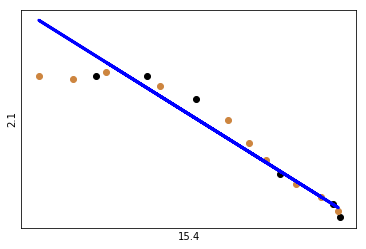

15.4 2.1
MAE: 0.44133
RMSE: 0.67376
R2: 0.800
Coefficient -0.5448934404472711
--------------------------




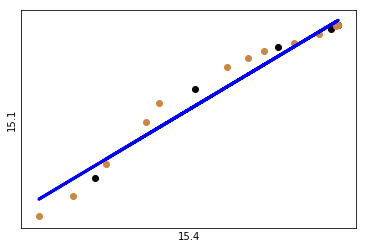

15.4 15.1
MAE: 0.69397
RMSE: 0.81008
R2: 0.956
Coefficient 1.0373166230489312
--------------------------


15.4 9.5
MAE: 1.40462
RMSE: 1.85954
R2: 0.963
Coefficient 3.1530557123722858
--------------------------




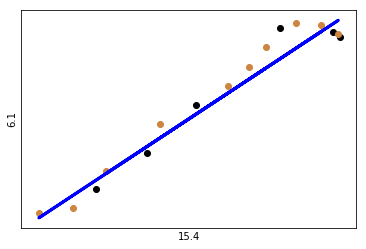

15.4 6.1
MAE: 0.95297
RMSE: 1.09023
R2: 0.962
Coefficient 1.5311211684423789
--------------------------


15.4 4.2
MAE: 1.26862
RMSE: 1.48345
R2: 0.801
Coefficient 1.2460472569306156
--------------------------




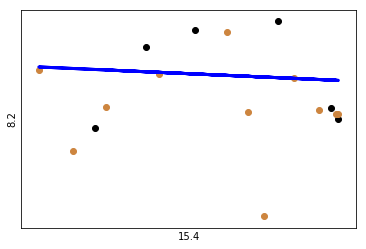

15.4 8.2
MAE: 0.97650
RMSE: 1.35595
R2: 0.000
Coefficient -0.03195610613284403
--------------------------


15.4 10.c
MAE: 2.86349
RMSE: 3.81434
R2: 0.000
Coefficient -5.238095238095215
--------------------------




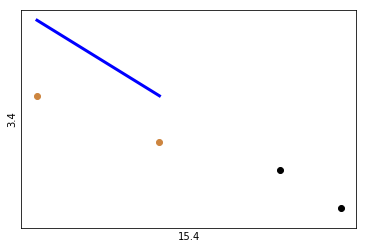

15.4 3.4
MAE: 0.08187
RMSE: 0.08430
R2: nan
Coefficient -0.024509803921568662
--------------------------


15.4 14.4
MAE: 2.42751
RMSE: 2.84405
R2: 0.709
Coefficient 0.9699513919575787
--------------------------


17.2 15.4
MAE: 1.02002
RMSE: 1.45168
R2: 0.831
Coefficient 159168.59731884714
--------------------------




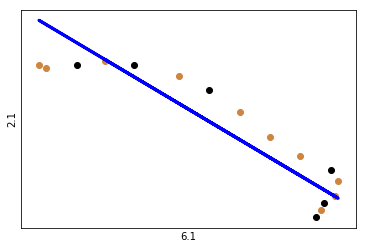

6.1 2.1
MAE: 0.62405
RMSE: 0.73159
R2: 0.764
Coefficient -0.3274414252646601
--------------------------




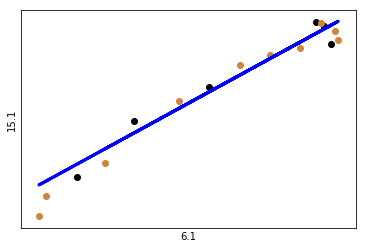

6.1 15.1
MAE: 0.70654
RMSE: 0.83222
R2: 0.956
Coefficient 0.6404595560944435
--------------------------


6.1 9.5
MAE: 1.82495
RMSE: 2.25758
R2: 0.946
Coefficient 1.7735687538963323
--------------------------


6.1 4.2
MAE: 1.63557
RMSE: 1.99291
R2: 0.641
Coefficient 0.647808735713133
--------------------------


6.1 8.2
MAE: 1.04201
RMSE: 1.39990
R2: 0.000
Coefficient 0.025084762575977936
--------------------------




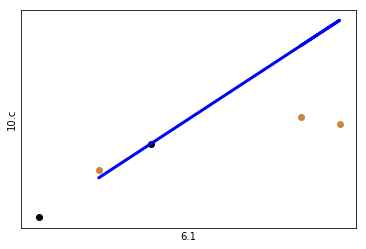

6.1 10.c
MAE: 0.91220
RMSE: 1.09168
R2: 0.000
Coefficient 2.6829268292683137
--------------------------




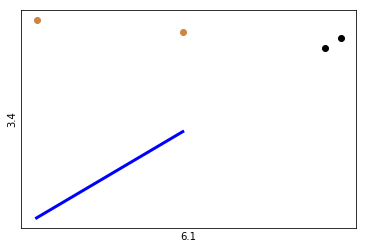

6.1 3.4
MAE: 0.81782
RMSE: 0.86051
R2: nan
Coefficient 0.06756756756756808
--------------------------


6.1 14.4
MAE: 2.15353
RMSE: 2.40614
R2: 0.792
Coefficient 0.6146670969254342
--------------------------


17.2 6.1
MAE: 1.66019
RMSE: 2.17215
R2: 0.849
Coefficient 251990.25243455017
--------------------------




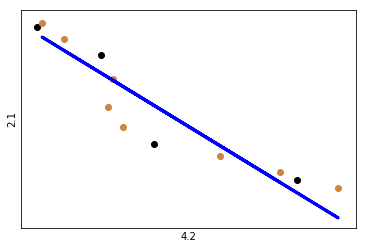

4.2 2.1
MAE: 0.46111
RMSE: 0.55552
R2: 0.845
Coefficient -0.4531459467624469
--------------------------


4.2 15.1
MAE: 1.22147
RMSE: 1.55182
R2: 0.620
Coefficient 0.628851311143608
--------------------------


4.2 9.5
MAE: 2.41136
RMSE: 2.90026
R2: 0.850
Coefficient 2.4838443036378712
--------------------------


4.2 8.2
MAE: 1.28914
RMSE: 1.81307
R2: 0.000
Coefficient -0.19381463518029785
--------------------------




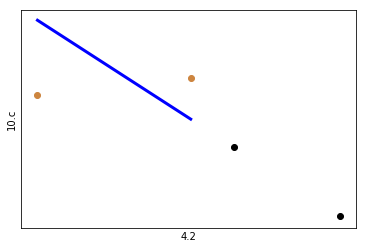

4.2 10.c
MAE: 0.33777
RMSE: 0.35196
R2: nan
Coefficient -0.28776978417266197
--------------------------


4.2 14.4
MAE: 3.85356
RMSE: 4.26361
R2: 0.000
Coefficient 1.0091743119266048
--------------------------


17.2 4.2
MAE: 2.16395
RMSE: 2.48422
R2: 0.442
Coefficient 192811.25551335007
--------------------------


8.2 2.1
MAE: 1.40273
RMSE: 1.59148
R2: 0.000
Coefficient 0.41011823857007085
--------------------------


8.2 15.1
MAE: 3.43824
RMSE: 4.02839
R2: 0.000
Coefficient 0.26296354210520195
--------------------------


8.2 9.5
MAE: 8.92735
RMSE: 10.08584
R2: 0.000
Coefficient 0.9918551094785761
--------------------------


8.2 10.c
MAE: 1.15513
RMSE: 1.64070
R2: 0.000
Coefficient 4.230769230769228
--------------------------




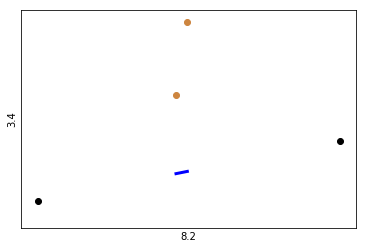

8.2 3.4
MAE: 0.09465
RMSE: 0.09916
R2: nan
Coefficient 0.02083333333333334
--------------------------


8.2 14.4
MAE: 7.20220
RMSE: 7.40219
R2: 0.000
Coefficient -3.485898151492269
--------------------------


17.2 8.2
MAE: 1.00822
RMSE: 1.35768
R2: 0.000
Coefficient 2678.8272706241637
--------------------------




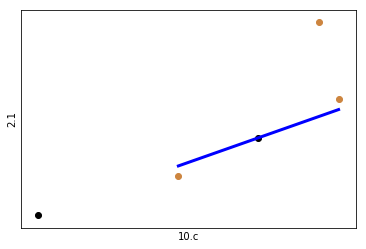

10.c 2.1
MAE: 0.20000
RMSE: 0.28690
R2: 0.228
Coefficient 0.3636363636363625
--------------------------




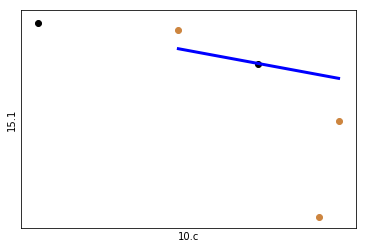

10.c 15.1
MAE: 0.36667
RMSE: 0.46755
R2: 0.000
Coefficient -0.19999999999999904
--------------------------


10.c 9.5
MAE: 2.15350
RMSE: 2.42711
R2: nan
Coefficient -2.7099999999999707
--------------------------


17.2 10.c
MAE: 0.18521
RMSE: 0.21924
R2: 0.621
Coefficient -113203.3141813909
--------------------------




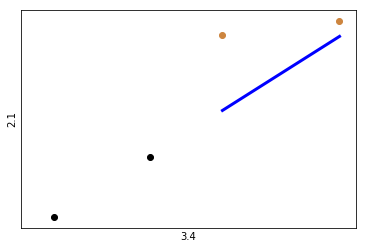

3.4 2.1
MAE: 0.96900
RMSE: 1.16293
R2: nan
Coefficient 25.999999999999964
--------------------------


3.4 15.1
MAE: 4.90900
RMSE: 5.53041
R2: nan
Coefficient -25.999999999999932
--------------------------


17.2 3.4
MAE: 0.07121
RMSE: 0.09159
R2: nan
Coefficient -4576.638093189507
--------------------------


14.4 2.1
MAE: 1.18049
RMSE: 1.24822
R2: 0.686
Coefficient -0.41612267258749397
--------------------------


14.4 15.1
MAE: 2.19809
RMSE: 2.41545
R2: 0.679
Coefficient 0.6924757281553388
--------------------------


14.4 9.5
MAE: 6.88541
RMSE: 7.57998
R2: 0.323
Coefficient 2.878220064724918
--------------------------


17.2 14.4
MAE: 2.96815
RMSE: 3.27029
R2: 0.615
Coefficient 135220.34938980473
--------------------------


17.2 2.1
MAE: 0.72251
RMSE: 0.98549
R2: 0.572
Coefficient -84913.7242682904
--------------------------


17.2 15.1
MAE: 1.33602
RMSE: 1.53387
R2: 0.852
Coefficient 166626.81475020255
--------------------------


17.2 9.5
MAE: 3.32077
RMSE: 4.29321
R2: 0.805
Coe

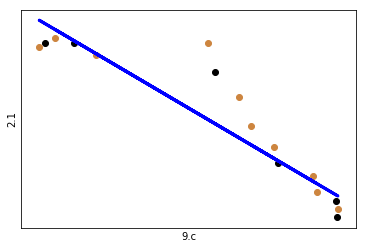

9.c 2.1
MAE: 0.51138
RMSE: 0.72781
R2: 0.767
Coefficient -0.1066010290609748
--------------------------


9.c 15.1
MAE: 1.36432
RMSE: 2.64077
R2: 0.561
Coefficient 0.204304013645866
--------------------------


9.c 9.5
MAE: 3.17327
RMSE: 5.36247
R2: 0.696
Coefficient 0.6017261981167601
--------------------------


9.c 17.8
MAE: 4.84024
RMSE: 6.94068
R2: 0.592
Coefficient 0.7290992816873229
--------------------------




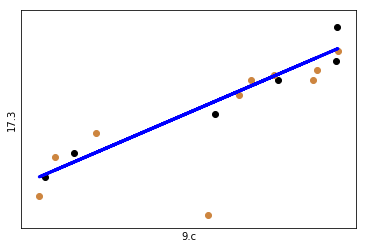

9.c 17.3
MAE: 0.04320
RMSE: 0.07718
R2: 0.525
Coefficient 0.0066993279889170435
--------------------------




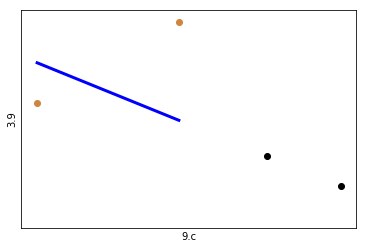

9.c 3.9
MAE: 0.02993
RMSE: 0.03251
R2: nan
Coefficient -0.001666666666666669
--------------------------


9.c 3.1
MAE: 5.51731
RMSE: 5.53425
R2: nan
Coefficient -0.38461538461538475
--------------------------


9.c 15.4
MAE: 1.07107
RMSE: 2.09051
R2: 0.633
Coefficient 0.1983611327774652
--------------------------


9.c 6.1
MAE: 1.86995
RMSE: 3.19725
R2: 0.672
Coefficient 0.31093701011824315
--------------------------


9.c 4.2
MAE: 1.67826
RMSE: 1.85002
R2: 0.690
Coefficient 0.22570550495551273
--------------------------




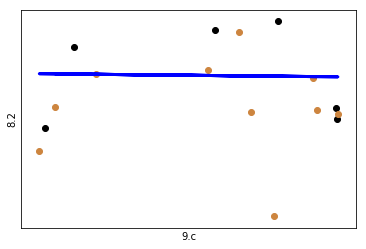

9.c 8.2
MAE: 0.99584
RMSE: 1.39097
R2: 0.000
Coefficient -0.0019249301495967938
--------------------------


9.c 10.c
MAE: 20.75333
RMSE: 24.51614
R2: 0.000
Coefficient -11.00000000000062
--------------------------




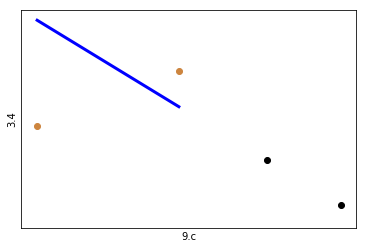

9.c 3.4
MAE: 0.07829
RMSE: 0.08722
R2: nan
Coefficient -0.006410256410256418
--------------------------


9.c 14.4
MAE: 4.05243
RMSE: 4.55057
R2: 0.255
Coefficient 0.14907661499666236
--------------------------


9.c 7.1
MAE: 4.12649
RMSE: 4.14264
R2: nan
Coefficient 0.3563362609786705
--------------------------




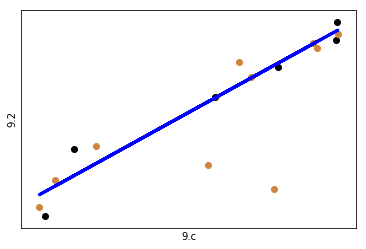

9.c 9.2
MAE: 0.17248
RMSE: 0.30328
R2: 0.515
Coefficient 0.027911504411554485
--------------------------




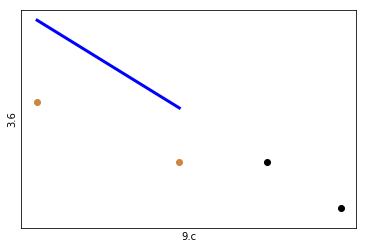

9.c 3.6
MAE: 0.09001
RMSE: 0.09181
R2: nan
Coefficient -0.007792207792207824
--------------------------


9.c 14.5
MAE: 4.86685
RMSE: 6.59337
R2: nan
Coefficient 0.5743589743589744
--------------------------


9.4 9.c
MAE: 5.45365
RMSE: 9.37813
R2: 0.550
Coefficient 4.977897147500532e-09
--------------------------




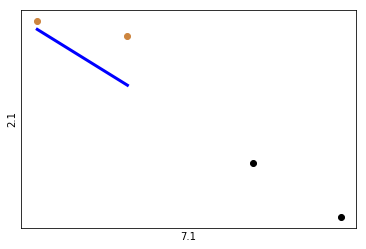

7.1 2.1
MAE: 0.58873
RMSE: 0.72282
R2: nan
Coefficient -0.3873239436619712
--------------------------


7.1 15.1
MAE: 4.21437
RMSE: 4.99852
R2: nan
Coefficient 0.44366197183098466
--------------------------




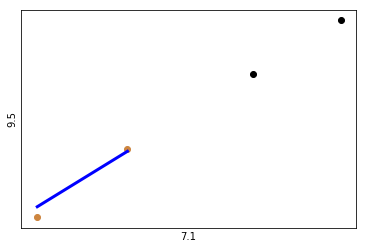

7.1 9.5
MAE: 0.93866
RMSE: 1.11494
R2: nan
Coefficient 2.7968309859154883
--------------------------


7.1 17.8
MAE: 4.40930
RMSE: 4.59422
R2: nan
Coefficient 4.0070422535211225
--------------------------




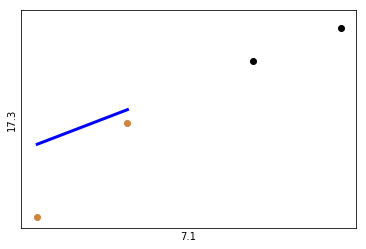

7.1 17.3
MAE: 0.07711
RMSE: 0.09411
R2: nan
Coefficient 0.021126760563380233
--------------------------


7.1 15.4
MAE: 2.20542
RMSE: 2.43400
R2: nan
Coefficient 0.704225352112675
--------------------------


7.1 6.1
MAE: 12.11169
RMSE: 12.68759
R2: nan
Coefficient -0.18309859154929414
--------------------------


7.1 8.2
MAE: 5.71507
RMSE: 5.82571
R2: nan
Coefficient -0.7992957746478864
--------------------------




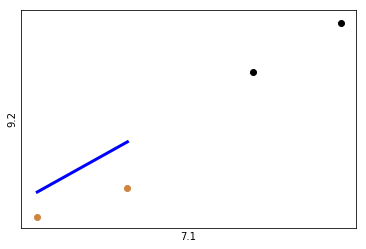

7.1 9.2
MAE: 0.16275
RMSE: 0.16993
R2: nan
Coefficient 0.0774647887323945
--------------------------


9.4 7.1
MAE: 2.30338
RMSE: 2.69208
R2: nan
Coefficient 1.4709843164066563e-09
--------------------------




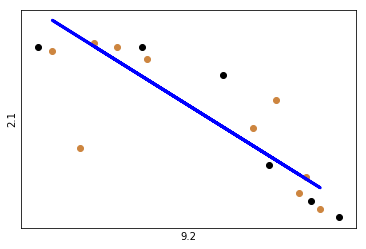

9.2 2.1
MAE: 0.73785
RMSE: 1.06426
R2: 0.501
Coefficient -3.561067372674705
--------------------------


9.2 15.1
MAE: 1.57282
RMSE: 2.47146
R2: 0.615
Coefficient 7.273712812652411
--------------------------


9.2 9.5
MAE: 3.95660
RMSE: 6.19136
R2: 0.595
Coefficient 20.927648766328023
--------------------------


9.2 17.8
MAE: 5.13216
RMSE: 6.95850
R2: 0.590
Coefficient 25.119668362014924
--------------------------




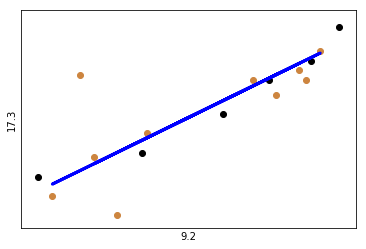

9.2 17.3
MAE: 0.04889
RMSE: 0.07782
R2: 0.517
Coefficient 0.23372117327388012
--------------------------




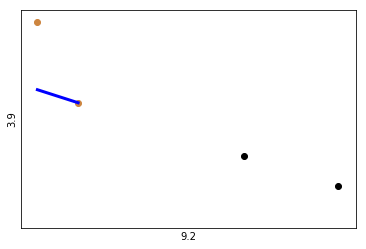

9.2 3.9
MAE: 0.01472
RMSE: 0.02079
R2: nan
Coefficient -0.043333333333333515
--------------------------


9.2 3.1
MAE: 2.00000
RMSE: 2.19317
R2: nan
Coefficient -10.000000000000036
--------------------------


9.2 15.4
MAE: 1.27772
RMSE: 2.03276
R2: 0.669
Coefficient 6.858050581759916
--------------------------


9.2 6.1
MAE: 2.31915
RMSE: 3.66485
R2: 0.569
Coefficient 10.682157040340003
--------------------------


9.2 4.2
MAE: 2.66702
RMSE: 3.16144
R2: 0.096
Coefficient 11.028943560057884
--------------------------


9.2 8.2
MAE: 1.00243
RMSE: 1.32489
R2: 0.000
Coefficient 0.18110499547133013
--------------------------




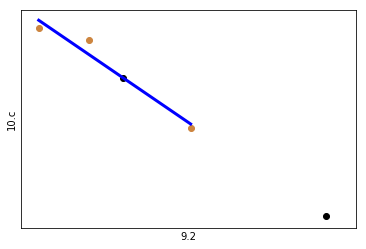

9.2 10.c
MAE: 0.06944
RMSE: 0.07773
R2: 0.952
Coefficient -9.166666666666723
--------------------------




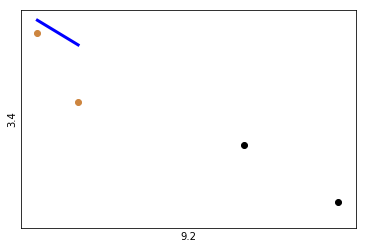

9.2 3.4
MAE: 0.03067
RMSE: 0.03643
R2: nan
Coefficient -0.16666666666666743
--------------------------


9.2 14.4
MAE: 4.55556
RMSE: 5.06483
R2: 0.077
Coefficient 7.539384846211553
--------------------------




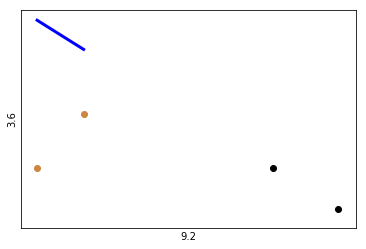

9.2 3.6
MAE: 0.15833
RMSE: 0.16992
R2: nan
Coefficient -0.33333333333333537
--------------------------


9.2 14.5
MAE: 2.52467
RMSE: 3.07857
R2: 0.612
Coefficient 14.933333333333387
--------------------------


9.4 9.2
MAE: 0.14724
RMSE: 0.23306
R2: 0.714
Coefficient 1.3933775663965205e-10
--------------------------


3.6 2.1
MAE: 2.15000
RMSE: 2.27706
R2: nan
Coefficient 14.999999999999934
--------------------------


3.6 15.1
MAE: 5.97000
RMSE: 7.21973
R2: nan
Coefficient -17.999999999999886
--------------------------


3.6 9.5
MAE: 11.63533
RMSE: 15.09890
R2: nan
Coefficient -114.31666666666628
--------------------------


3.6 17.8
MAE: 12.57000
RMSE: 16.05009
R2: nan
Coefficient -134.4999999999994
--------------------------




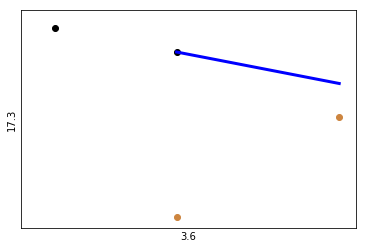

3.6 17.3
MAE: 0.16833
RMSE: 0.20200
R2: nan
Coefficient -0.6666666666666623
--------------------------


3.6 15.4
MAE: 4.91500
RMSE: 5.91172
R2: nan
Coefficient -30.499999999999833
--------------------------


3.6 6.1
MAE: 11.31000
RMSE: 11.77880
R2: nan
Coefficient 5.499999999999947
--------------------------


3.6 8.2
MAE: 2.68167
RMSE: 3.05894
R2: nan
Coefficient 35.66666666666651
--------------------------


9.4 3.6
MAE: 0.15151
RMSE: 0.18698
R2: nan
Coefficient -3.573534404202492e-11
--------------------------


14.5 2.1
MAE: 1.25993
RMSE: 1.26009
R2: nan
Coefficient -0.29017857142857123
--------------------------


14.5 15.1
MAE: 3.54594
RMSE: 4.97447
R2: 0.000
Coefficient 0.29017857142857084
--------------------------


14.5 17.8
MAE: 2.68830
RMSE: 2.93169
R2: nan
Coefficient 3.2678571428571437
--------------------------




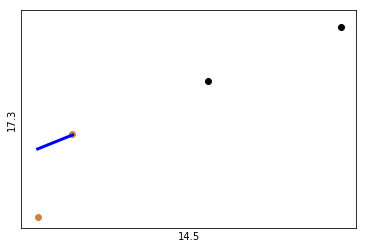

14.5 17.3
MAE: 0.07064
RMSE: 0.09869
R2: nan
Coefficient 0.024553571428571428
--------------------------




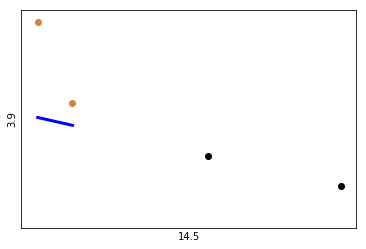

14.5 3.9
MAE: 0.02560
RMSE: 0.03008
R2: nan
Coefficient -0.0029017857142857174
--------------------------


14.5 3.1
MAE: 3.41138
RMSE: 4.09112
R2: nan
Coefficient -0.6696428571428572
--------------------------


14.5 15.4
MAE: 2.64563
RMSE: 3.43601
R2: 0.337
Coefficient 0.4553571428571427
--------------------------


14.5 6.1
MAE: 11.93819
RMSE: 12.47109
R2: nan
Coefficient -0.16517857142857034
--------------------------


14.5 8.2
MAE: 2.86036
RMSE: 3.29457
R2: 0.000
Coefficient -0.5357142857142859
--------------------------




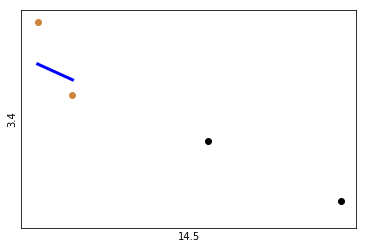

14.5 3.4
MAE: 0.02397
RMSE: 0.02645
R2: nan
Coefficient -0.011160714285714298
--------------------------


9.4 2.1
MAE: 0.47556
RMSE: 0.59168
R2: 0.846
Coefficient -5.0609195506507e-10
--------------------------


9.4 15.1
MAE: 0.91919
RMSE: 1.07645
R2: 0.927
Coefficient 1.0669675016082684e-09
--------------------------


9.4 9.5
MAE: 1.39832
RMSE: 1.71124
R2: 0.969
Coefficient 3.124104771367487e-09
--------------------------


9.4 17.8
MAE: 2.08500
RMSE: 2.46047
R2: 0.949
Coefficient 3.2574352430019974e-09
--------------------------


9.4 17.3
MAE: 0.02603
RMSE: 0.03318
R2: 0.912
Coefficient 3.019956265318879e-11
--------------------------


9.4 15.4
MAE: 0.45388
RMSE: 0.57361
R2: 0.972
Coefficient 9.953544720813692e-10
--------------------------


9.4 6.1
MAE: 0.86092
RMSE: 1.26390
R2: 0.949
Coefficient 1.675457420695531e-09
--------------------------


9.4 4.2
MAE: 1.04961
RMSE: 1.27856
R2: 0.852
Coefficient 1.3258417959375148e-09
--------------------------


9.4 8.2
MAE: 1.18882
RM

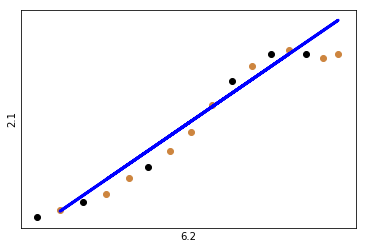

6.2 2.1
MAE: 0.35400
RMSE: 0.43442
R2: 0.917
Coefficient 0.543268289312295
--------------------------




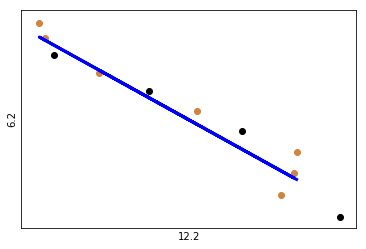

12.2 6.2
MAE: 0.40513
RMSE: 0.50470
R2: 0.935
Coefficient -2.511447015861889
--------------------------




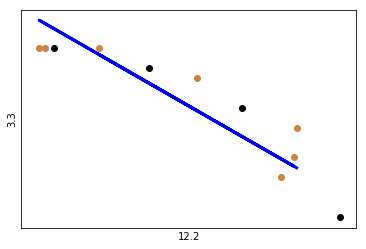

12.2 3.3
MAE: 0.22971
RMSE: 0.25713
R2: 0.754
Coefficient -0.8285943629806327
--------------------------


12.2 8.1
MAE: 1.67854
RMSE: 2.61226
R2: 0.000
Coefficient 0.8783394195656352
--------------------------




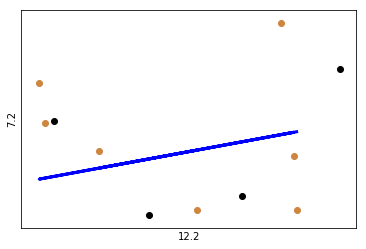

12.2 7.2
MAE: 0.26892
RMSE: 0.30291
R2: 0.000
Coefficient 0.11231077093532095
--------------------------


16.a 2.1
MAE: 2.77500
RMSE: 3.85438
R2: nan
Coefficient -0.4999999999999993
--------------------------


16.a 15.1
MAE: 1.01000
RMSE: 1.12471
R2: 0.942
Coefficient 0.49999999999999867
--------------------------


16.a 17.8
MAE: 43.14385
RMSE: 51.61925
R2: nan
Coefficient 5.6307692307692285
--------------------------




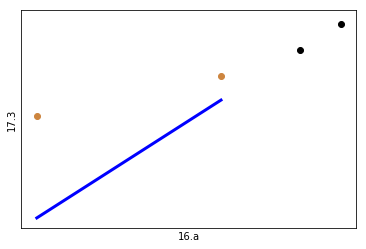

16.a 17.3
MAE: 0.26404
RMSE: 0.31004
R2: nan
Coefficient 0.04230769230769229
--------------------------




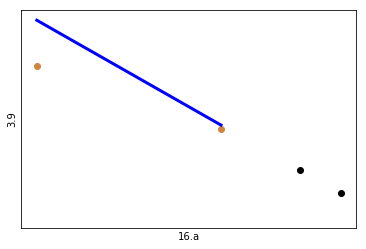

16.a 3.9
MAE: 0.01375
RMSE: 0.01809
R2: nan
Coefficient -0.005000000000000003
--------------------------


16.a 3.1
MAE: 5.66923
RMSE: 6.99644
R2: nan
Coefficient -1.1538461538461533
--------------------------


16.a 15.4
MAE: 1.93487
RMSE: 2.86538
R2: 0.539
Coefficient 0.784615384615384
--------------------------


16.a 6.1
MAE: 14.17808
RMSE: 15.09299
R2: nan
Coefficient -0.28461538461538244
--------------------------


16.a 8.2
MAE: 7.86462
RMSE: 10.20628
R2: 0.000
Coefficient -0.9230769230769226
--------------------------




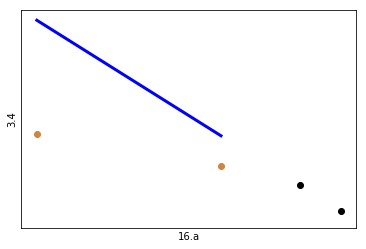

16.a 3.4
MAE: 0.14015
RMSE: 0.16238
R2: nan
Coefficient -0.019230769230769235
--------------------------


16.a 9.c
MAE: 25.00500
RMSE: 29.61331
R2: nan
Coefficient 2.999999999999997
--------------------------




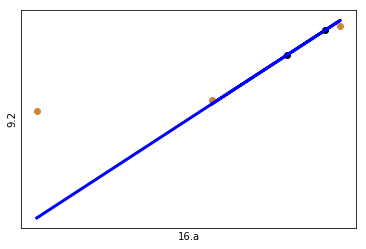

16.a 9.2
MAE: 0.45974
RMSE: 0.73293
R2: 0.000
Coefficient 0.1153846153846149
--------------------------


16.a 14.5
MAE: 9.34128
RMSE: 13.52644
R2: 0.000
Coefficient 1.7230769230769223
--------------------------


16.a 6.2
MAE: 10.27981
RMSE: 12.28551
R2: nan
Coefficient -1.3884615384615375
--------------------------


16.a 3.3
MAE: 3.87500
RMSE: 4.76616
R2: nan
Coefficient -0.49999999999999994
--------------------------


16.a 8.1
MAE: 5.85712
RMSE: 6.47163
R2: nan
Coefficient -0.5269230769230766
--------------------------




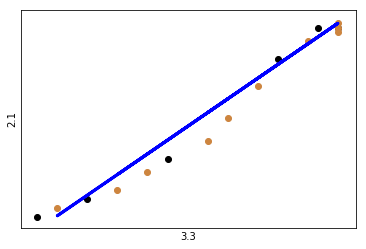

3.3 2.1
MAE: 0.24916
RMSE: 0.30885
R2: 0.958
Coefficient 1.5220152413209143
--------------------------


3.3 15.1
MAE: 1.86766
RMSE: 2.21104
R2: 0.692
Coefficient -2.629720575783232
--------------------------


3.3 9.5
MAE: 2.32184
RMSE: 2.59996
R2: 0.929
Coefficient -9.686497797356827
--------------------------


3.3 17.8
MAE: 1.28746
RMSE: 1.90172
R2: 0.969
Coefficient -10.633573243014391
--------------------------




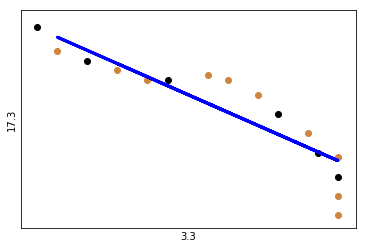

3.3 17.3
MAE: 0.04601
RMSE: 0.05659
R2: 0.745
Coefficient -0.09119390347163416
--------------------------




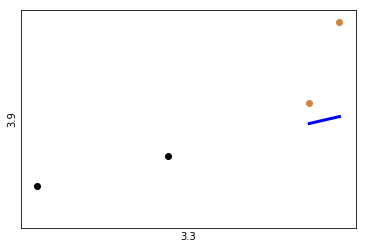

3.3 3.9
MAE: 0.02500
RMSE: 0.02968
R2: nan
Coefficient 0.010000000000000005
--------------------------


3.3 3.1
MAE: 3.27308
RMSE: 4.00259
R2: nan
Coefficient 2.307692307692307
--------------------------


3.3 15.4
MAE: 1.13277
RMSE: 1.36849
R2: 0.843
Coefficient -2.682345469940728
--------------------------


3.3 6.1
MAE: 2.60387
RMSE: 2.83128
R2: 0.743
Coefficient -3.933403895004232
--------------------------




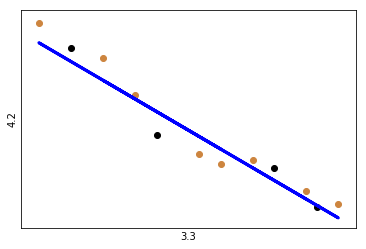

3.3 4.2
MAE: 0.73642
RMSE: 0.80523
R2: 0.941
Coefficient -3.4144376899696054
--------------------------


3.3 8.2
MAE: 1.03322
RMSE: 1.43258
R2: 0.000
Coefficient 0.2674005080440308
--------------------------




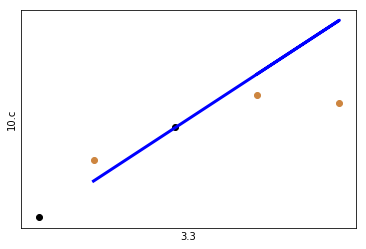

3.3 10.c
MAE: 0.51333
RMSE: 0.62599
R2: 0.000
Coefficient 2.1999999999999984
--------------------------




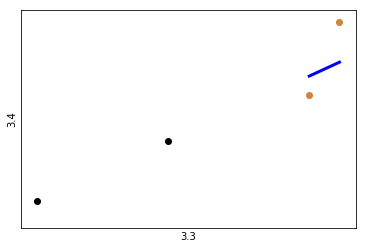

3.3 3.4
MAE: 0.02473
RMSE: 0.02628
R2: nan
Coefficient 0.03846153846153847
--------------------------


3.3 14.4
MAE: 3.26896
RMSE: 3.55022
R2: 0.546
Coefficient -2.7019867549668866
--------------------------


3.3 9.c
MAE: 6.61640
RMSE: 7.77733
R2: 0.691
Coefficient -12.710414902624892
--------------------------


3.3 7.1
MAE: 1.57818
RMSE: 1.91389
R2: nan
Coefficient -2.5818181818181865
--------------------------




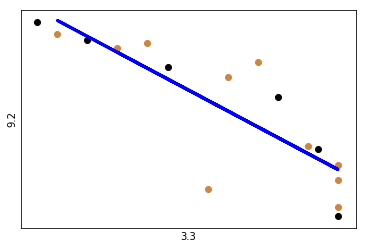

3.3 9.2
MAE: 0.19501
RMSE: 0.26521
R2: 0.629
Coefficient -0.35732430143945787
--------------------------




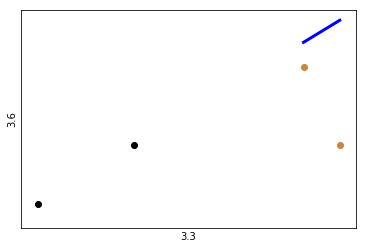

3.3 3.6
MAE: 0.07625
RMSE: 0.09187
R2: nan
Coefficient 0.07500000000000026
--------------------------




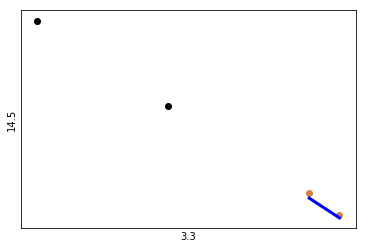

3.3 14.5
MAE: 0.20654
RMSE: 0.21747
R2: nan
Coefficient -3.4461538461538437
--------------------------




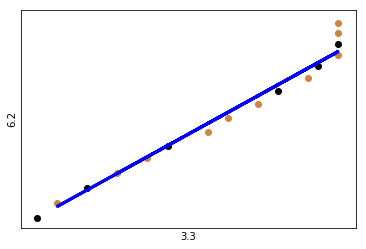

3.3 6.2
MAE: 0.44807
RMSE: 0.61452
R2: 0.955
Coefficient 2.776799322607958
--------------------------


3.3 8.1
MAE: 1.21285
RMSE: 1.87755
R2: 0.000
Coefficient 0.2098221845893314
--------------------------




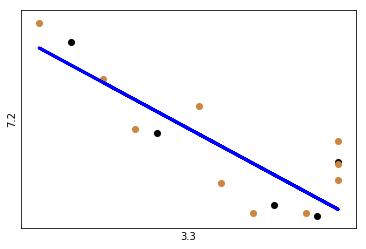

3.3 7.2
MAE: 0.25140
RMSE: 0.28116
R2: 0.573
Coefficient -0.4299559471365648
--------------------------


8.1 2.1
MAE: 1.51369
RMSE: 1.66645
R2: 0.000
Coefficient 0.569162531088469
--------------------------


8.1 15.1
MAE: 3.55971
RMSE: 4.19364
R2: 0.000
Coefficient 0.26461587832804395
--------------------------


8.1 9.5
MAE: 8.29517
RMSE: 9.55783
R2: 0.036
Coefficient -0.3995875656482736
--------------------------


8.1 17.8
MAE: 11.41782
RMSE: 12.95312
R2: 0.000
Coefficient -3.730856952928907
--------------------------




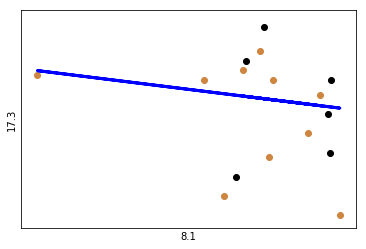

8.1 17.3
MAE: 0.08612
RMSE: 0.11285
R2: 0.000
Coefficient -0.012412465186645436
--------------------------




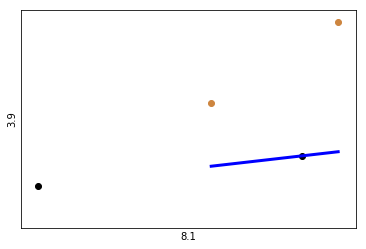

8.1 3.9
MAE: 0.04183
RMSE: 0.04423
R2: nan
Coefficient 0.009489051094890521
--------------------------


8.1 3.1
MAE: 7.15657
RMSE: 7.41156
R2: nan
Coefficient 2.1897810218978107
--------------------------


8.1 15.4
MAE: 2.82906
RMSE: 3.49435
R2: 0.000
Coefficient -0.4272501174771631
--------------------------


8.1 6.1
MAE: 5.12365
RMSE: 5.82042
R2: 0.000
Coefficient 0.3400648703166701
--------------------------


8.1 4.2
MAE: 5.70610
RMSE: 9.07617
R2: 0.000
Coefficient -3.8652373660030666
--------------------------




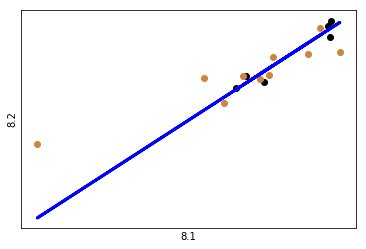

8.1 8.2
MAE: 0.72812
RMSE: 1.08476
R2: 0.136
Coefficient 1.2145763372339573
--------------------------




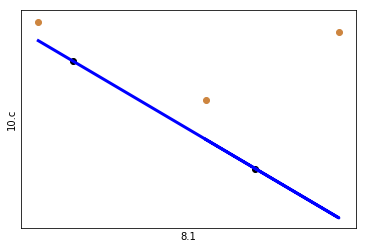

8.1 10.c
MAE: 0.83333
RMSE: 1.12983
R2: 0.000
Coefficient -2.972972972972973
--------------------------




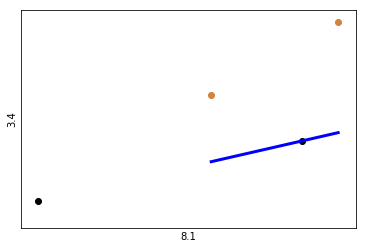

8.1 3.4
MAE: 0.07361
RMSE: 0.07589
R2: nan
Coefficient 0.03649635036496355
--------------------------


8.1 14.4
MAE: 8.32868
RMSE: 9.48632
R2: 0.000
Coefficient -3.495026151163982
--------------------------


8.1 9.c
MAE: 11.02143
RMSE: 13.80728
R2: 0.025
Coefficient -1.4358689298690013
--------------------------


8.1 7.1
MAE: 5.85048
RMSE: 5.90940
R2: nan
Coefficient -1.9319727891156488
--------------------------




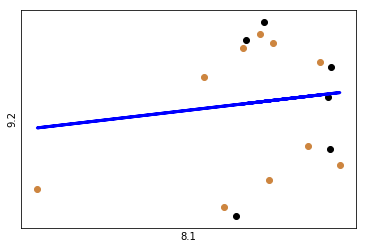

8.1 9.2
MAE: 0.40848
RMSE: 0.42992
R2: 0.026
Coefficient 0.03792506676141224
--------------------------




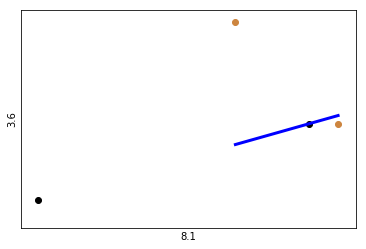

8.1 3.6
MAE: 0.05138
RMSE: 0.06819
R2: nan
Coefficient 0.03448275862068981
--------------------------


8.1 14.5
MAE: 5.59281
RMSE: 5.61460
R2: nan
Coefficient -3.2700729927007304
--------------------------


8.1 6.2
MAE: 2.86621
RMSE: 3.26310
R2: 0.000
Coefficient 0.8306265830764118
--------------------------




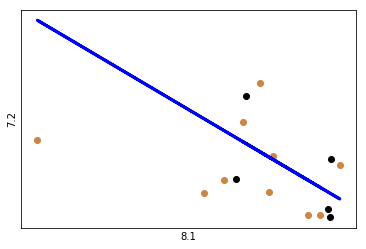

8.1 7.2
MAE: 0.50294
RMSE: 0.60872
R2: 0.000
Coefficient -0.3078916395501794
--------------------------




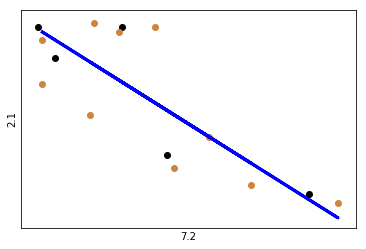

7.2 2.1
MAE: 0.84412
RMSE: 0.99265
R2: 0.566
Coefficient -2.9775900073475365
--------------------------


7.2 15.1
MAE: 2.92284
RMSE: 3.65261
R2: 0.159
Coefficient 4.281410727406315
--------------------------


7.2 9.5
MAE: 6.16316
RMSE: 7.62515
R2: 0.386
Coefficient 16.241421748714163
--------------------------


7.2 17.8
MAE: 6.29795
RMSE: 7.77733
R2: 0.487
Coefficient 18.256245407788374
--------------------------




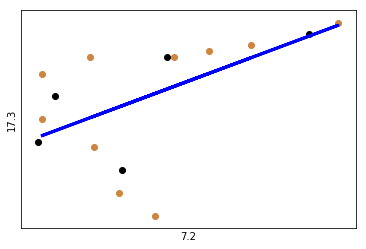

7.2 17.3
MAE: 0.07864
RMSE: 0.10068
R2: 0.192
Coefficient 0.13666421748714166
--------------------------


7.2 15.4
MAE: 2.26197
RMSE: 2.88771
R2: 0.299
Coefficient 4.88299044819985
--------------------------


7.2 6.1
MAE: 4.22224
RMSE: 4.92118
R2: 0.223
Coefficient 7.269470977222626
--------------------------


7.2 4.2
MAE: 1.30872
RMSE: 1.56699
R2: 0.778
Coefficient 6.033123612139149
--------------------------




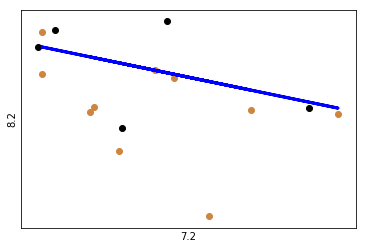

7.2 8.2
MAE: 0.97315
RMSE: 1.39888
R2: 0.000
Coefficient -1.0518001469507676
--------------------------




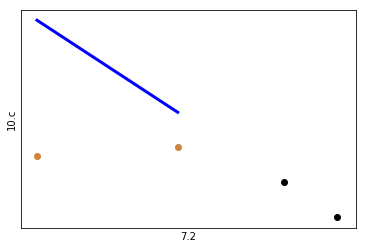

7.2 10.c
MAE: 0.97857
RMSE: 1.13681
R2: nan
Coefficient -2.857142857142921
--------------------------


7.2 14.4
MAE: 3.91161
RMSE: 4.92879
R2: 0.126
Coefficient 4.702336096458173
--------------------------


7.2 9.c
MAE: 8.66251
RMSE: 10.76158
R2: 0.408
Coefficient 23.08706833210872
--------------------------


7.2 7.1
MAE: 4.43707
RMSE: 5.04700
R2: nan
Coefficient 3.463414634146359
--------------------------




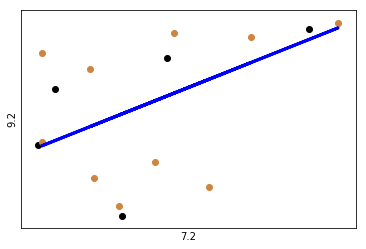

7.2 9.2
MAE: 0.35380
RMSE: 0.41448
R2: 0.094
Coefficient 0.5249816311535638
--------------------------




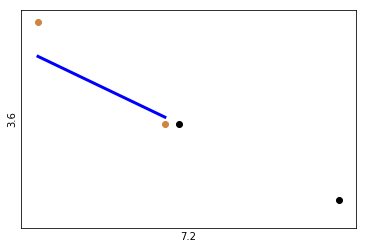

7.2 3.6
MAE: 0.01618
RMSE: 0.01950
R2: nan
Coefficient -0.08823529411764748
--------------------------


7.2 6.2
MAE: 1.71103
RMSE: 2.14677
R2: 0.446
Coefficient -4.729243203526814
--------------------------




In [27]:
keptPairs = list()
processedPairs = list()
notPercentTargets = ['12.2', '9.4', '8.4', '17.2', '17.19']   # work on this
highValueTargets = ['9.4', '17.19']
discardedPairs = list()
edgecolor = list()

n_connections = 0

for targetx in targets:     #loop over all rows
        
        for targety in targets:    #loop over all rows except the one we're in now
            # avoid double processing of reverse pairs
            if not set([targetx, targety]) in processedPairs:
                processedPairs.extend([set([targetx, targety])])
                
                if not targety==targetx:
                    
                    if ((targety in notPercentTargets and not targetx in notPercentTargets) or targety in highValueTargets):
                        y = targetx
                        x = targety
                        targetx = x
                        targety = y


                    X = final_t_shuffled[targetx].reshape(-1,1)
                    Y = final_t_shuffled[targety].reshape(-1,1)

                    # apply mask to lists to filter out pairs containing any NaNs
                    mask = ~pd.isnull(X) & ~pd.isnull(Y)

                    X = X[mask]
                    Y = Y[mask]


                    # Split the data into training/testing sets
                    split = math.floor(2/3 * len(X))
                    X_train = X[:-split]
                    Y_train = Y[:-split]

                    X_valid = X[-split:]
                    Y_valid = Y[-split:]


                    if (len(X_train) > 1):

                        X_train = X_train.reshape(-1, 1)
                        Y_train = Y_train.reshape(-1, 1)
                        
                        X_valid = X_valid.reshape(-1, 1)
                        Y_valid = Y_valid.reshape(-1, 1)

                        linreg = linear_model.LinearRegression()
                        linreg.fit(X_train, Y_train)
                        
                        # Make predictions using the validation values
                        y_pred = linreg.predict(X_valid)
                        mae, rae, rmse, r2 = compute_error(Y_valid, y_pred)
                        
                        
                        coef = linreg.coef_[0][0]
                        
                        # filter out independant variables (coefficient close to 0, coefficient > 100)
                        if (0.001 < np.abs(coef) < 100):
                        
                            if targety in notPercentTargets:

                                if 0<=mae<0.1: # 1 percent tolerance (converted to tonnes)
                                    #print('MAE', targetx, targety, mae)
                                    keptPairs.extend([tuple((targetx, targety))])

                                    if coef > 0: edgecolor.append('g')
                                    else: edgecolor.append('r')

                                    plt.scatter(X_train, Y_train,  color='black')
                                    plt.scatter(X_valid, Y_valid, color='peru')
                                    plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                                    plt.xticks(())
                                    plt.yticks(())
                                    plt.xlabel(targetx)
                                    plt.ylabel(targety)
                                    plt.show()

                                    n_connections = n_connections + 1

                                else: discardedPairs.extend([[targetx, targety]])


                            else:
                                if 1 > mae > 0: # tolerate 1 percent error
                                    keptPairs.extend([tuple((targetx, targety))])
                                    
                                    if coef > 0: edgecolor.append('g')
                                    else: edgecolor.append('r')

                                    plt.scatter(X_train, Y_train,  color='black')
                                    plt.scatter(X_valid, Y_valid, color='peru')
                                    plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                                    plt.xticks(())
                                    plt.yticks(())
                                    plt.xlabel(targetx)
                                    plt.ylabel(targety)
                                    plt.show()

                                    n_connections = n_connections + 1

                                else: discardedPairs.extend([[targetx, targety]])
                        
                        else: discardedPairs.extend([[targetx, targety]])

                        print(targetx, targety)
                        
                        print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (mae, rmse, r2))
                        print('Coefficient', coef)
                        print('--------------------------')
                        print('\n')

#print(keptPairs)

In [28]:
print("Total number of connections found: ", n_connections)

Total number of connections found:  104


In [29]:
print(keptPairs)

[('12.2', '2.1'), ('12.2', '15.1'), ('12.2', '8.4'), ('12.2', '17.3'), ('12.2', '15.4'), ('12.2', '6.1'), ('12.2', '4.2'), ('12.2', '9.2'), ('15.1', '2.1'), ('9.5', '2.1'), ('8.4', '17.3'), ('8.4', '15.4'), ('8.4', '6.1'), ('8.4', '4.2'), ('8.4', '9.2'), ('8.4', '2.1'), ('8.4', '15.1'), ('8.4', '6.2'), ('8.4', '3.3'), ('8.4', '7.2'), ('17.8', '2.1'), ('17.8', '17.3'), ('17.8', '15.4'), ('17.8', '4.2'), ('17.8', '10.c'), ('17.8', '3.4'), ('17.3', '2.1'), ('17.3', '15.1'), ('17.3', '3.9'), ('17.3', '15.4'), ('17.3', '10.c'), ('17.3', '3.4'), ('3.9', '3.4'), ('3.1', '2.1'), ('3.1', '3.4'), ('15.4', '2.1'), ('15.4', '15.1'), ('15.4', '6.1'), ('15.4', '8.2'), ('15.4', '3.4'), ('6.1', '2.1'), ('6.1', '15.1'), ('6.1', '10.c'), ('6.1', '3.4'), ('4.2', '2.1'), ('4.2', '10.c'), ('8.2', '3.4'), ('10.c', '2.1'), ('10.c', '15.1'), ('3.4', '2.1'), ('9.c', '2.1'), ('9.c', '17.3'), ('9.c', '3.9'), ('9.c', '8.2'), ('9.c', '3.4'), ('9.c', '9.2'), ('9.c', '3.6'), ('7.1', '2.1'), ('7.1', '9.5'), ('7.1', '

In [30]:
# seems like the high value targets are discarded more than the others, else, evenly distributed
print(discardedPairs)

[['17.19', '12.2'], ['17.19', '9.5'], ['17.19', '8.4'], ['17.19', '17.8'], ['17.19', '17.3'], ['17.19', '15.4'], ['17.19', '6.1'], ['17.19', '4.2'], ['17.19', '8.2'], ['17.19', '10.c'], ['17.19', '14.4'], ['17.19', '17.2'], ['17.19', '9.c'], ['17.19', '9.2'], ['9.4', '17.19'], ['9.4', '6.2'], ['9.4', '3.3'], ['9.4', '8.1'], ['9.4', '7.2'], ['12.2', '9.5'], ['12.2', '17.8'], ['12.2', '8.2'], ['12.2', '14.4'], ['12.2', '17.2'], ['12.2', '9.c'], ['9.4', '12.2'], ['17.19', '15.1'], ['17.19', '6.2'], ['17.19', '3.3'], ['17.19', '8.1'], ['17.19', '7.2'], ['17.19', '2.1'], ['9.5', '15.1'], ['8.4', '9.5'], ['8.4', '17.8'], ['8.4', '8.2'], ['8.4', '14.4'], ['8.4', '17.2'], ['8.4', '9.c'], ['9.4', '8.4'], ['8.4', '8.1'], ['17.8', '15.1'], ['17.8', '9.5'], ['17.8', '3.9'], ['17.8', '3.1'], ['17.8', '6.1'], ['17.8', '8.2'], ['17.8', '14.4'], ['17.2', '17.8'], ['17.2', '9.c'], ['17.2', '7.1'], ['17.2', '9.2'], ['17.2', '3.6'], ['17.2', '14.5'], ['9.4', '17.2'], ['17.3', '9.5'], ['17.3', '3.1'], ['1

## 2. Graphical Models

In [31]:
import networkx as nx

In [32]:
G1 = nx.Graph()
G1.add_edges_from(keptPairs)

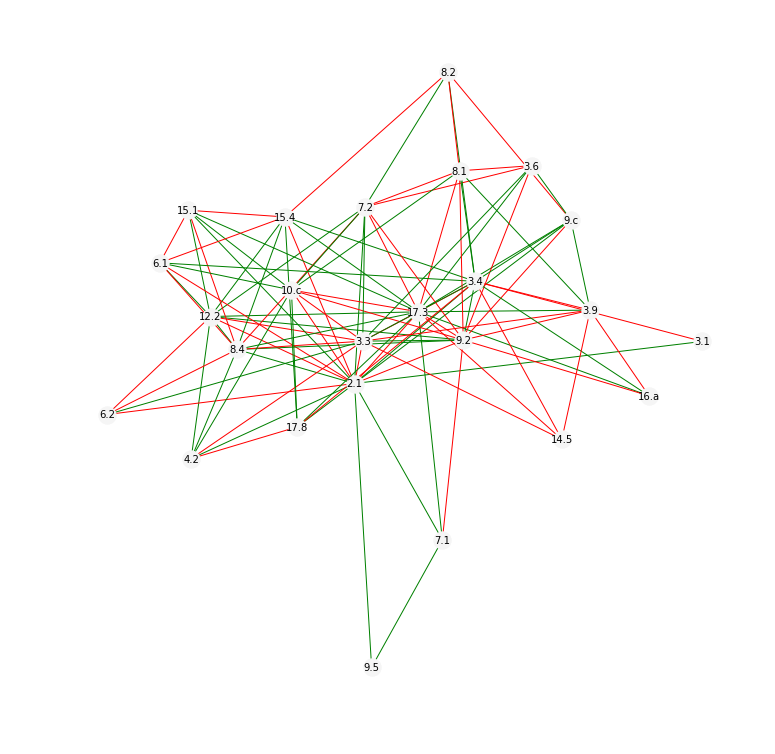

In [33]:
pos2 = nx.spring_layout(G1) # choose layout
# default

plt.figure(1,figsize=(10,10)) 
nx.draw(G1,pos2, with_labels=True, edge_color=edgecolor, node_color='whitesmoke', font_size=10)
plt.show()

In this plot, the most connected and therefore most influential nodes are located in the middle of the graph.

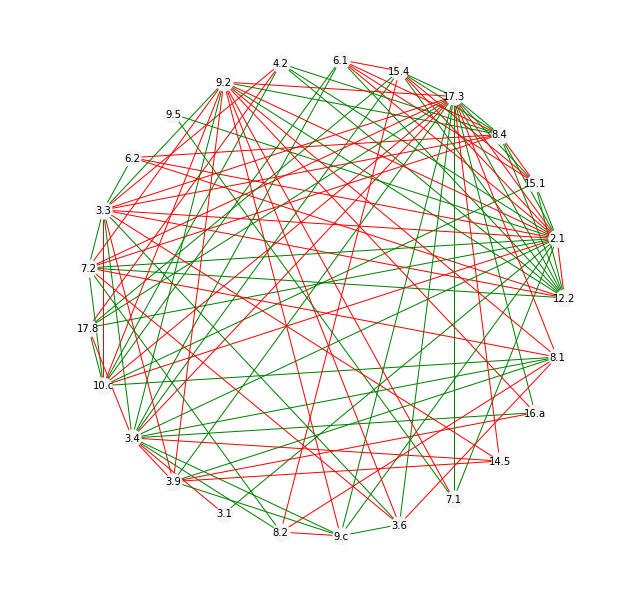

In [34]:
pos = nx.circular_layout(G1) # choose layout
# default

plt.figure(1,figsize=(8,8)) 
nx.draw(G1,pos, with_labels=True, edge_color=edgecolor, node_color='whitesmoke', font_size=10)
plt.show()

In [35]:
clique_list = list(nx.find_cliques(G1))
clique_list

[['2.1', '6.2', '12.2', '8.4', '3.3'],
 ['2.1', '4.2', '3.3', '10.c'],
 ['2.1', '4.2', '3.3', '8.4', '12.2'],
 ['2.1', '4.2', '17.8', '10.c'],
 ['2.1', '3.1', '3.4'],
 ['2.1', '9.5', '7.1'],
 ['2.1', '6.1', '15.1', '10.c'],
 ['2.1', '6.1', '15.1', '8.4', '15.4', '12.2'],
 ['2.1', '6.1', '3.4', '15.4'],
 ['2.1', '17.3', '15.4', '12.2', '8.4', '15.1'],
 ['2.1', '17.3', '15.4', '17.8', '3.4'],
 ['2.1', '17.3', '15.1', '10.c'],
 ['2.1', '17.3', '9.2', '3.3', '3.4'],
 ['2.1', '17.3', '9.2', '3.3', '7.2', '10.c'],
 ['2.1', '17.3', '9.2', '3.3', '7.2', '8.4', '12.2'],
 ['2.1', '17.3', '9.2', '9.c', '3.4'],
 ['2.1', '17.3', '9.2', '7.1'],
 ['2.1', '17.3', '17.8', '10.c'],
 ['8.2', '3.4', '8.1'],
 ['8.2', '3.4', '15.4'],
 ['8.2', '3.4', '9.c'],
 ['8.2', '7.2', '8.1'],
 ['3.9', '3.4', '17.3', '9.2', '8.1'],
 ['3.9', '3.4', '17.3', '9.2', '16.a'],
 ['3.9', '3.4', '17.3', '9.2', '3.3'],
 ['3.9', '3.4', '17.3', '9.2', '9.c'],
 ['3.9', '3.4', '17.3', '14.5', '3.3'],
 ['8.1', '17.3', '9.2', '7.2', '1

In [36]:
length = 0
for c in clique_list:
    if len(c) > length:
        length = len(c)
        max_clique = c

In [37]:
max_clique
import itertools

def complete_graph_from_list(L, create_using=None):
    G = nx.empty_graph()
    if len(L)>1:
        if G.is_directed():
            edges = itertools.permutations(L,2)
        else:
            edges = itertools.combinations(L,2)
        G.add_edges_from(edges)
    return G


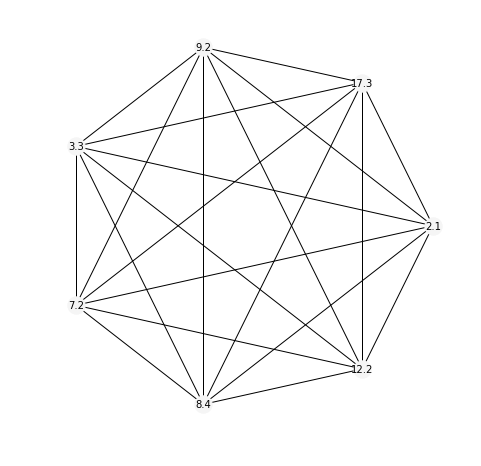

In [38]:
cliqueGraph = complete_graph_from_list(max_clique)
#cliqueGraph.add_nodes_from(max_clique)
pos9 = nx.shell_layout(cliqueGraph)
plt.figure(1,figsize=(6,6)) 
nx.draw(cliqueGraph,pos9, with_labels=True, font_size=10, node_color='whitesmoke')
plt.show()

## 2. Build temporal model to infer missing observations

We have a temporal model with missing observations as NaNs, and want to infer them

In [39]:
# convert data to a matrix
y = df.as_matrix()
y = y[:(6*24*1)]
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=144, D=43


In [40]:
# What is observed and what is missing?

#perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)] # missing indexes
ix_obs1 = perm1[int(missing_perc * N):] # observed indexes
y_mis1 = y[ix_mis1,7]
y_obs1 = y[ix_obs1,7]

#perm2 = np.random.permutation(N)
ix_mis2 = perm2[:int(missing_perc * N)] # missing indexes
ix_obs2 = perm2[int(missing_perc * N):] # observed indexes
y_mis2 = y[ix_mis2,8]
y_obs2 = y[ix_obs2,8]

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
print("N_obs:", N_obs)
print("N_mis:", N_mis)

NameError: name 'perm1' is not defined

## Define STAN model

In [ ]:
SDG_STAN="""
data {
    int<lower = 0> N_obs;    // we might need such a variable for each observed variable because they could be different
    int<lower = 0> N_mis;    // how many do we want to infer
    int<lower = 1, upper = N_obs + N_mis> ix_obs1[N_obs];    // index for observed variable 1
    int<lower = 1, upper = N_obs + N_mis> ix_mis1[N_mis];
    int<lower = 1, upper = N_obs + N_mis> ix_obs2[N_obs];    // index for observed variable 2 -> more?
    int<lower = 1, upper = N_obs + N_mis> ix_mis2[N_mis];
    real y_obs1[N_obs];         // observed time-series data for variable 1
    real y_obs2[N_obs];         // observed time-series data for variable 2
}
parameters {
    vector[1] beta[2];            // state transition coefficients
    corr_matrix[2] Omega;    // 2 because of two observed variables -> in our case 
    vector<lower=0>[2] tau;
    real<lower=0> sigma;       // observation noise
    matrix[T,2] z;             // vector of latent states
    real y_mis1[N_mis];        // missing time-series data (to infer) -> for variable 1
    real y_mis2[N_mis];        // missing time-series data (to infer) -> for variable 2 -> more?
}
model {
    for(i in 1:2)                   // 2 again because of two observed variables -> more?
        beta[i] ~ normal(0,1);            // prior on the auto-regressive coefficients
    tau ~ cauchy(0,1);
    Omega ~ lkj_corr(10.0);         // STAN manual Section 63.1  
    sigma ~ cauchy(0,1);            // prior on the variance
    
    z[1,:] ~ normal(0,1);           // prior on first state
    for(t in 2:T) {
        vector[2] mu;
        mu[1] = beta[1]' * z[(t-1):(t-1),1];
        mu[2] = beta[2]' * z[(t-1):(t-1),2];
        z[t,:] ~ multi_normal(mu, quad_form_diag(Omega, tau)); // latent dynamics
    }
    
    y1 ~ normal(z[:,1], sigma);    // likelihood
    y2 ~ normal(z[:,2], sigma);    // likelihood -> more variables?
}
"""

In [ ]:
# prepare data for STAN model
data = {'N_obs': N_obs, 'N_mis': N_mis, 
        'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
        'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}

# add more ix_obs3, etc. if we take more variables to infer

In [ ]:
%%time
# create STAN model object (compile STAN model)
sm = pystan.StanModel(model_code=SDG_STAN)

In [ ]:
# run inference using MCMC sampling
fit = sm.sampling(data=data, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
fit.plot(["tau","sigma","lp__"]) # take vars from temporal model
plt.show()

#### Compute mean and standard devitions for the imputed values of the time-series and visualize them (in comparison with the corresponding true values):

In [ ]:
# get mean and standard devitions for predictions
y_hat = samples["y_mis1"].mean(axis=0)
y_std = samples["y_mis1"].std(axis=0)

In [ ]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
#plt.plot(ix_mis, y_hat + y_std, "r--")
#plt.plot(ix_mis, y_hat - y_std, "r--")
plt.legend(["true","forecast","forecast + stddev","forecast - stddev"])

Compute error statistics of the model's imputations:

In [ ]:
# insert def compute_error if deleted above
mae, rae, rmse, r2 = compute_error(y_mis1, y_hat) #for missing variables
print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))